<h1><center>UFO Sightings in the United States of America</center></h1> 

<h3><center>Hope Winovich, Benjamin Colebrook, Neha Satapathy</center></h3> 

<img src="https://www.publicdomainpictures.net/pictures/280000/nahled/ufos-1538575302GDM.jpg">

## Introduction 
The National UFO Reporting Center (NUFORC) is an organization in the US that investigates reported sightings of UFO's (Unidentified Flying Objects) or alien contact. You can visit their website here http://www.nuforc.org/. They keep an extensive record of all of the reported UFO sightings, especially in the US. Since the organizaton was only founded in 1974, some of their older data is not very accurate and often incomplete. In this tutorial, we will explore the data they do have (up to 2013), make some plots and maps that describe trends, and make some predictions about the data.

This tutorial will walk through the process of gathering, scraping, tidying, analyzing and conducting hypothesis testing on the data. The goal of this tutorial is to see the trends in reported UFO sightings and to predict what the future holds in terms of frequency of reported UFO sightings. We will also offer some possible explanations to our discovered results.
## Downloading Data
The data for this tutorial can be downloaded from https://www.kaggle.com/NUFORC/ufo-sightings#scrubbed.csv. The data has 11 columns that correspond to each report of a UFO sighting all over the world. For the purposes of this tutorial, we will only use data from the United States and we will further scrape the data for deeper analysis later. The data goes back to reports from 1949, but we will use data from 2000 to 2013 for analysis. To start, download the data file from the link above and save it to your current directory. The file that we will be using is called "complete.csv"; you can ignore the scrubbed.csv file. 

## Outline
1. Getting Started: Scraping and Tidying Data

2. Exploratory Data Analysis

3. Linear Regression and Hypothesis Testing

4. Machine Learning Predictions

5. Conclusion

# Getting Started: Scraping and Tidying Data
## 1.1: Required Libraries
First, we need to import the libraries that are used throughout this project. These libraries allow us to do everything we need to do our analysis. Pandas and numpy allow us to represent our data in easy to use data types such as DataFrame. Some, such as seaborn and matplotlib allow us to plot our data in scatter and bar graphs. Folium is used for representing data on beautiful, interactive maps. Finally, sklearn is used for our linear regression modelling. By importing these libraries, we will have all the necessary tools for our analysis. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn import linear_model
from sklearn import model_selection
from statsmodels import api as sm
import re
import operator 
from collections import OrderedDict
!pip install folium
import folium
from folium.map import *
from folium import plugins
import os
from IPython.core.display import HTML
from itertools import cycle, islice
from statsmodels.formula.api import ols
#!pip install --upgrade pip

Note: If you need to download folium or update pip you can delete the pound signs in front of the two commands with the pounds signs and it will download and upgrade those built-in functions for you. For more information on the import system for Python go to https://docs.python.org/3/reference/import.html. 

## 1.2 Loading and Displaying Data
The following code will take the comma-separated values file (CSV) that you downloaded and begin to tidy the data. We will use pandas, an open-source library for Python to help us read in the CSV file. For more information on the pandas library, you can visit https://pandas.pydata.org/. 

Our first task is to get rid of columns that are not necessary for our analysis. Next, since in our analysis we are only concerned with the UFO sightings in the US, we need to restrict our data to only include entries in the United States. Another way that we can tidy the data is to convert the datetime column to datetime objects because in the original CSV file, they are stored as string objects and this makes the dates more difficult to parse later on during analysis. Lastly, we can appropriately capitalize the proper nouns and abbreviations in the data and change the numeric values from string representation to float.

In [2]:
# Read in the data on UFO Sightings
data = pd.read_csv('complete.csv', error_bad_lines=False, warn_bad_lines = False, low_memory = False)

# Drop unnecessary columns such as 'date posted' and 'duration (hours/min)'.
# 'date posted' is irrelavent since it is when the sighting was reported, not when it took place ('datetime').
# 'duration (hours/min)' is the same as duration (seconds) just represented differently.
# We also dropped the comments section since this is unnecessary for analysis but could be useful
# when representing the sightings on a map for the poppup.
data['duration'] = data['duration (seconds)']
data = data.drop(columns = ['comments','duration (hours/min)','duration (seconds)', 'date posted'])

# Only interested in sightings within the US
data = data[data['country'] == 'us']

# Make datetime column objects real datetime objects
# Must be sure to covert times represented by '24:00' to '23:59' for the datetime object.
twenty4 = re.compile('.*24:00$')
for index, row in data.iterrows():
    dt = data.at[index, 'datetime']
    if twenty4.match(str(dt)):
        data.at[index, 'datetime'] = data.at[index, 'datetime'].replace(r'24:00', '23:59')
datetimes = pd.to_datetime(data['datetime'] + ":00")
data['datetime'] = datetimes
data.sort_values(by=['datetime'], inplace=True)



# Capitalize appropriate proper nouns and abbreviations in data
data['state'] = data['state'].apply(lambda x: x.upper())
data['country'] = data['country'].apply(lambda x: x.upper())
data['city'] = data['city'].apply(lambda x: x.capitalize())

# Convert numeric values from string to float
data.latitude = data.latitude.astype(float)
data.longitude = data.longitude.astype(float)
data.duration = data.duration.apply(pd.to_numeric, errors = 'coerce')

# This data will be used in the machine learning predictions
data_65 = data[(data['datetime'] >= '1950-01-01') & (data['datetime'] < '2014-01-01')]
data_25 = data[(data['datetime'] >= '1990-01-01') & (data['datetime'] < '2014-01-01')]

# To narrow our focus, we are only concerned with data from 2000 through 2013
data = data[(data['datetime'] >= '2000-01-01') & (data['datetime'] < '2014-01-01')]

data.head()

datetime           city state country    shape   latitude  \
12085 2000-01-01 00:01:00    Bakersfield    CA      US      NaN  35.373333   
12086 2000-01-01 00:01:00  New york city    NY      US   sphere  40.714167   
12087 2000-01-01 00:03:00    Los angeles    CA      US  unknown  34.052222   
12088 2000-01-01 00:23:00      San diego    CA      US    light  32.715278   
12094 2000-01-01 03:00:00  Bellefontaine    OH      US    light  40.361111   

        longitude  duration  
12085 -119.017778       0.0  
12086  -74.006389     120.0  
12087 -118.242778     120.0  
12088 -117.156389      15.0  
12094  -83.759722      10.0

In our final form of the dataset, we now have entries only from 2000-2013. This six year period is where all of our analysis below will come from. Our original dataset started in the 1940's and went all the way through May of 2014. It is safe to assume that the early entries may not be as likely to be reported or as accurate in location, duration or time as the later entries. We also converted each column to be stored as the dtype that is most appropriate for the data being represented.

# Exploratory Data Analysis
## 2.1 Frequency of Sightings per State
To begin our analysis, we will look at the frequency of sightings. This information will tell us a lot about the trends in reporting UFO's over time. If we find anything significant here, we can use this later in our hypothesis testing. We will make a bar graph that plots the frequency per state from 2000-2014. A bar graph is useful in this case since it makes it very easy for a reader to see the differences in quantities over a period of time.

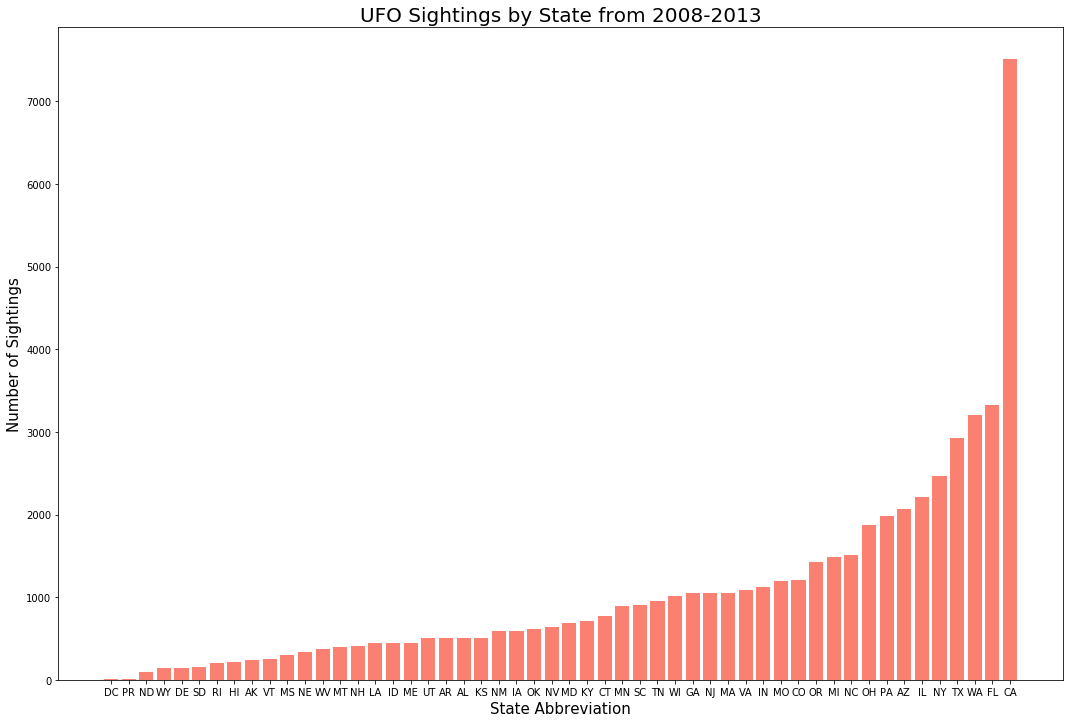

In [3]:
# Bar graph of frequencies of sightings

# Makes a dictionary that has the states as keys 
# and the number of sightings as values for each state
frq = {}
for i in range(len(data)):
    cur = data.iat[i,2]
    if frq.get(cur):
        frq[cur] += 1
    else:
        frq[cur] = 1
sorted_frq = sorted(frq.items(), key=operator.itemgetter(1))

# Plots the bar graph with parameters that show the abbreviations of 
# all of the states on the x axis
zip(*sorted_frq) # zip is used to map groups (in this case by states) 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size
plt.bar(*zip(*sorted_frq), color = 'salmon') # plots the tuples of the dictionary frq

# Labeling the bar graph
plt.title("UFO Sightings by State from 2008-2013", fontdict={'fontsize':20})
plt.xlabel("State Abbreviation", fontdict={'fontsize':15})
plt.ylabel("Number of Sightings", fontdict={'fontsize':15})
plt.show()

Analysis: From the bar graph we can see that California has a much higher amount of reported sightings than any other state. It is nearly double the second runner-up which is Florida. It is not immediately clear that there is a region of the country where most of the reported sightings have happened because California, Florida, Washington, Texas and New York are the top 5 states in terms of number of reported sightings and they are not in the same region. However, there might be a correlation between population of a state and the number of reported sightings. From intuition, we know that these top five states have metropolitan areas with high population density and that could be correlated to number of reported sightings. 

## 2.2 Heat Map of UFO Sightings
Above we disussed how states we presume to have high population density have more reported sightings. To check this, we will use Python's Folium library to create a heat map of the UFO sightings in the US. We will plot each sighting by location (latitude and longitude). In a heat map, the red (hot) areas have more data points while the blue (cold) areas have less. This is a useful tool to see where sightings are clustered. If our prediction is correct, there will be clusters near cities and less reported sightings in rural areas. We will also save the map in a html file incase you are having trouble viewing the map in your browser.

If you want to learn more about using the folium module in Python, go to https://python-visualization.github.io/folium/modules.html.

In [4]:
# Create the map
map_ufo = folium.Map(location=[39.8, -98.6], zoom_start=4)

# Convert the latitudes and longitudes to (n, 2) nd-array format for heatmap
ufoArr = data[['latitude', 'longitude']].values

# Add the children to the heat map
map_ufo.add_child(plugins.HeatMap(ufoArr, radius=15))

# Save the map to the file 'map_ufo.html'
map_ufo.save(os.path.join('map_ufo.html'))
map_ufo

Take some time to interact with the map above. You will see that the UFO sightings are indeed concentrated in urban areas such as Los Angeles, San Francisco Bay Area, Boston, Houston, Austin, New York City, Orlando, Dallas, Miami, and Seattle. If we were to correlate UFO sightings with population density, it is easy to see there would be a strong correlation. The link, https://www2.census.gov/geo/pdfs/maps-data/maps/thematic/us_popdensity_2010map.pdf, shows a map based on population density per county from the U.S. Census in 2010 and it looks similar to the heat map that we made above. This indicates there is a strong correlation between population density and frequency of UFO sightings. This confirms our suspicion that areas with higher populaton desity report more UFO sightings. It makes sense if you think about it too; more people, more eyes, more sightings.

## 2.3 UFO Sightings Over Time
In the following analysis, we will look for any trends in the data that have to do with the most frequent times of the reported sightings from 2000-2013. To do this, we will make plots to find out the most common month, year, day of the week and hour of the day for the years 2000-2013 to find out if there is a particular time when most of the reports of UFOs are being made.

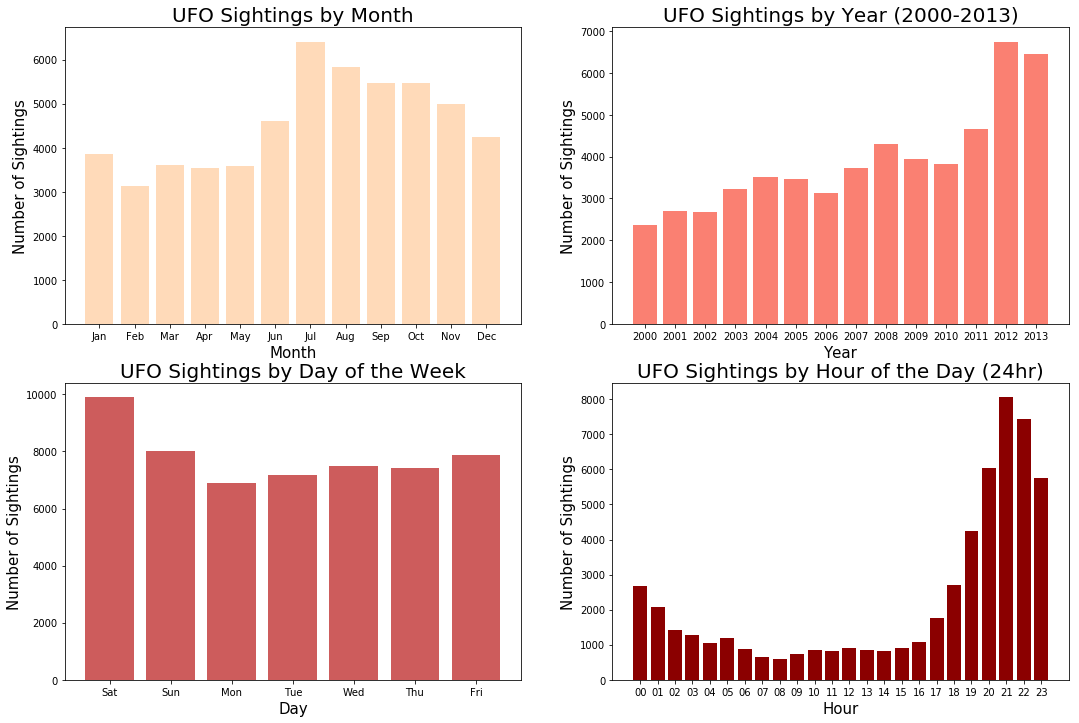

In [5]:
# Dicitonaries to measure frequency 
months = {}
years = {}
days = {}
hours = {}

# Goes through each row of the data set to get the 
# datetime object that corresponds to the specific time measurement
for index, row in data.iterrows():
    month = row['datetime'].strftime("%b")
    yr = row['datetime'].strftime("%Y")
    day = row['datetime'].strftime("%a")
    hr = row['datetime'].strftime("%H")
    # Add the key if not present, otherwise increment frequency
    if month in months.keys():
        months[month] = months[month] + 1
    else:
        months[month] = 1
    if yr in years.keys():
        years[yr] = years[yr] + 1
    else:
        years[yr] = 1
    if day in days.keys():
        days[day] = days[day] + 1
    else:
        days[day] = 1
    if hr in hours.keys():
        hours[hr] = hours[hr] + 1
    else:
         hours[hr] = 1
# Sorts the hours of the day (24 hours)
hours = dict(sorted(hours.items()))

# Makes subplots 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 18
fig_size[1] = 12
plt.rcParams["figure.figsize"] = fig_size

fig, ax = plt.subplots(nrows=2, ncols=2)

# Plots all 4 plots for: Month, Year, Day and Hour
plt.subplot(2, 2, 1)
plt.title("UFO Sightings by Month", fontdict={'fontsize':20})
plt.xlabel("Month", fontdict={'fontsize':15})
plt.ylabel("Number of Sightings", fontdict={'fontsize':15})
plt.bar(range(len(months)), list(months.values()), align='center', color = 'peachpuff')
plt.xticks(range(len(months)), list(months.keys()))

plt.subplot(2, 2, 2)
plt.title("UFO Sightings by Year (2000-2013)", fontdict={'fontsize':20})
plt.xlabel("Year", fontdict={'fontsize':15})
plt.ylabel("Number of Sightings", fontdict={'fontsize':15})
plt.bar(range(len(years)), list(years.values()), align='center', color = 'salmon')
plt.xticks(range(len(years)), list(years.keys()))

plt.subplot(2, 2, 3)
plt.title("UFO Sightings by Day of the Week", fontdict={'fontsize':20})
plt.xlabel("Day", fontdict={'fontsize':15})
plt.ylabel("Number of Sightings", fontdict={'fontsize':15})
plt.bar(range(len(days)), list(days.values()), align='center', color = 'indianred')
plt.xticks(range(len(days)), list(days.keys()))

plt.subplot(2, 2, 4)
plt.title("UFO Sightings by Hour of the Day (24hr)", fontdict={'fontsize':20})
plt.xlabel("Hour", fontdict={'fontsize':15})
plt.ylabel("Number of Sightings", fontdict={'fontsize':15})
plt.bar(range(len(hours)), list(hours.values()), align='center', color = 'darkred')
plt.xticks(range(len(hours)), list(hours.keys()))

# Display 4 plots as subplots
plt.show()

Analysis: We get a lot of information regarding the times of the highest number of reported UFO sightings from these subplots. First, from the UFO Sightings by Month graph we see that the greatest number of sightings occur in July from 2000-2013. The other summer months are the runner-ups for greatest number of sightings. This most likely occurs because people are outside in the summer more than other months of the year because of the warmer weather so people are more likely to see UFOs. 

The next plot, UFO Sightings by Year from 2000-2013 shows that on average the number of sightings increases each year. 
One possible reason for the increase of sightings of UFOs could be because of the increasing popularity of drones. As cited in this article, https://www.dronethusiast.com/history-of-drones/, the FAA issued the first commercial drone permits in 2006 and popularity has increased since then. This includes recreation flying, commerical use and military use. 

The plot, UFO Sightings by Day of the Week shows the most reported sightings from 2000-2013 for each day of the week. The most popular day for reported UFO sightings is Saturday. The last plot UFO Sightings by Hour of the Day (24hr) shows a similar analysis but for hours of the day in 24 hour format. The most popular hour of the day for reported sightings is 21:00 and 22:00 which is when it is dark outside in most places around the country. Around 21:00 people are awake and may be outside, especially in the summer, and may see objects lite up in the sky and report them as a UFO. 

## 2.4 Duration Map
Another feature that the dataset contains is duration of the sighting. To see if there is a correlation between locaton and duration, we will make a map of this. Here we will plot each entry on the map except this time, the radius of the circle is equivalent to the duration of the sighting divided by 4 (so that it is easier to see on the map). So when the UFO was spotted for a longer duration, the larger you will see the circle on the map. We will ignore all of the cases where the duration is less than 1000 seconds since they would just appear as tiny dots on the map, have little affect on what we are looking for, and take up too much processing power when interacting with the map.

In [6]:
# Make a smaller data set here to show duration from 2009-2013. 
data_cur = data[(data['datetime'] >= '2009-01-01')]

# Create the map of the US
map_duration = folium.Map(location=[39.8, -98.6], zoom_start=4)

# Make the feature group for duration
fg = FeatureGroup(name='Duration')

# For each entry in the dataset, add the circle to the feature group
for index, row in data_cur.iterrows():
    dur = row['duration']
    if dur >=1000:
        fg.add_child(folium.Circle(
            radius= dur/4.0,
            location=[row['latitude'], row['longitude']],
            # popup='<b>Loc: </b>' + location + '</br>' +'<b>Date: </b>' +date + '</br>' + '<b>Time: </b>' + time+ '<b>Shape: </b>' + shape + '<b>Duration: </b>' + dur,
            color='lightcoral',
        ))

# Add the feature group to the map
map_duration.add_child(fg)

# Save the map to the file 'map_duration.html'
map_duration.save('map_duration.html')
map_duration

In this map, we see that the sightings with the longest duration happen near the East coast or large bodies of water. Further, the longest ones don't necessarily happen in highly populated areas. In fact, in most of the more urban areas, you have very short durations. These suspected correlations, however, are not very strong and thus we will disregard them for further analysis. If we did find a stronger correlaton, we could use this in our next section.

# Linear Regression and Hypothesis Testing
Plots the linear regression for the frequency of sightings by year from 2000-2013. First, we will make a dataframe that has the information that we need for the linear regression model. Then, we will look at the summary of the regression in order to determine if our hypothesis that there is a relationship between time and number of sightings reported is true. 

For the hypothesis testing, we determine if our hypothesis is correct by looking at the p-value and the r-squared value. For the p-value, we will test with alpha = .05 (95%) and for our hypothesis to be correct p <= alpha. Further, we will look at r-squared to determine how well our data fits the model. In our case, a higher r-squared value means that the regression model fits the data well. 

## 3.1 Tidying Data for Linear Regression
First, lets tidy the data and make our dataframe for the regression analysis.

In [7]:
# Replaces NaN in data to tidy it up for linear regression  
data = data.replace(np.NaN, 0)

In [8]:
# Makes a dataframe for the years and frequency to use for linear regression analysis
data_years = pd.DataFrame(list(years.items()), columns=['Year','Frequency'])

# Casts year and hour to unsigned ints to make a linear regression model
data_years['Year'] = data_years['Year'].astype('uint32')
data_years['Frequency'] = data_years['Frequency'].astype('uint32')
#data.dtypes

data_years

Year  Frequency
0   2000       2366
1   2001       2703
2   2002       2681
3   2003       3218
4   2004       3514
5   2005       3458
6   2006       3135
7   2007       3732
8   2008       4309
9   2009       3937
10  2010       3825
11  2011       4666
12  2012       6750
13  2013       6463

## 3.2 Linear Regression Modeling
Now we are ready to fit our linear regression model using scikit which will use the least squares method of statistics. For an explanation of the least squares method, you can reference https://web.williams.edu/Mathematics/sjmiller/public_html/BrownClasses/54/handouts/MethodLeastSquares.pdf. 

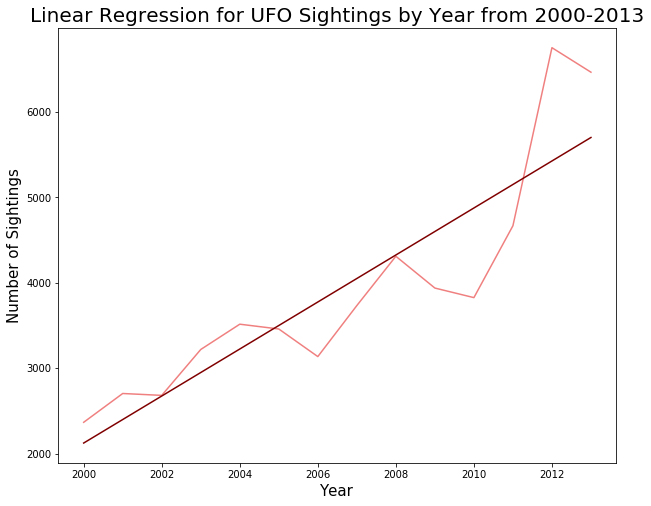

In [9]:
# Fits a linear regression model using scikit
import numpy as np
from sklearn import datasets, linear_model 

reg = linear_model.LinearRegression()
e2_X = [[x] for x in data_years['Year'].values]
e2_Y = [[y] for y in data_years['Frequency'].values]
regfit = reg.fit(e2_X, e2_Y)
freq_pred = []
# adds all of the data 
for x in data_years['Year'].values:
    freq_pred.append(regfit.predict(x)[0][0])
data_years['freq_pred'] = pd.DataFrame(freq_pred, index= data_years.index)

# plots the life exp vs yr 
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size
# Labeling the bar graph
plt.title("Linear Regression for UFO Sightings by Year from 2000-2013", fontdict={'fontsize':20})
plt.xlabel("Year", fontdict={'fontsize':15})
plt.ylabel("Number of Sightings", fontdict={'fontsize':15})
plt.plot(data_years['Year'], data_years['Frequency'], color = 'lightcoral')
plt.plot(data_years['Year'], data_years['freq_pred'], color = 'maroon')


Analysis: This linear regression model shows an increasing correlation between time and number of sightings. 

## 3.3 Further Regression Modeling
Below is another way to picture the data as a regression model that shows a positive slope. 

Text(-2.45,0.5,'Number of Sightings')

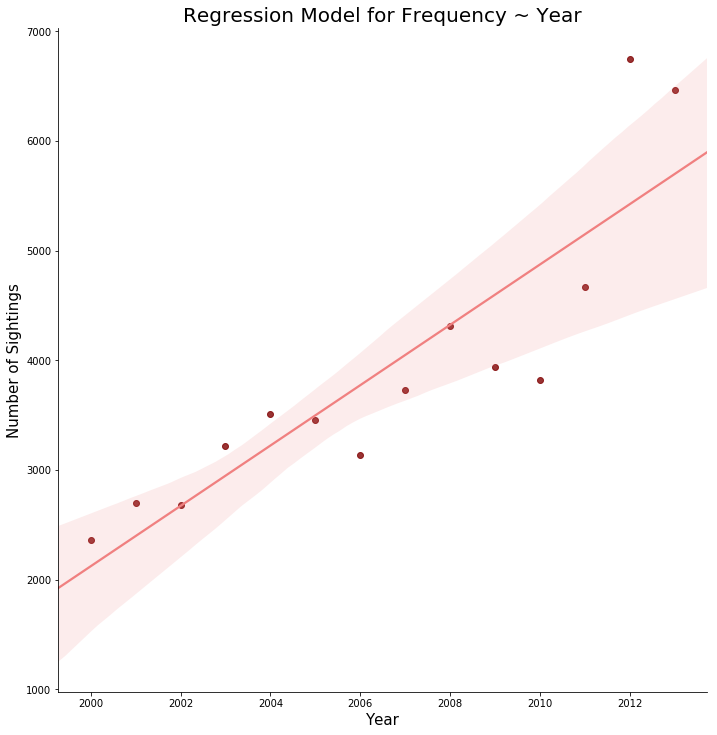

In [10]:
# Plots regression model to see a view of the 95% confidence interval for the regression
# the 95% CI is the default for the shadow of the regression line for a lmplot

sns.lmplot('Year', 'Frequency', data=data_years, height=10,fit_reg = True, line_kws={'color': 'lightcoral'}, scatter_kws = {'color':'maroon'})
plt.title("Regression Model for Frequency ~ Year", fontdict={'fontsize':20})
plt.xlabel("Year", fontdict={'fontsize':15})
plt.ylabel("Number of Sightings", fontdict={'fontsize':15})

Note: sns.lmplot draws a scatterplot of Year and Frequency from data_years and then fits the regression model Frequency ~ Year

## 3.4 Regression Summary  
Now let's look at the summary of the regression using the built-in function OLS that is the ordinary least squares method. 

In [11]:
# Fits the regression line for the Frequency Vs. Year
# using least squares method
regression = ols(formula='Frequency ~ Year', data=data_years).fit()
# Displays regression summary 
regression.summary()

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1394: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Frequency   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.759
Method:                 Least Squares   F-statistic:                     41.88
Date:                Sat, 15 Dec 2018   Prob (F-statistic):           3.06e-05
Time:                        03:06:13   Log-Likelihood:                -109.27
No. Observations:                  14   AIC:                             222.5
Df Residuals:                      12   BIC:                             223.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -5.48e+05   8.53e+04     -6.426      0.000   -7.34e+05   -3.62e+05
Year         275.0703     42.505      6.472      0.000     182.461     367.680
==============================================================================
Omnibus:                        0.872   Durbin-Watson:                   1.075
Prob(Omnibus):                  0.647   Jarque-Bera (JB):                0.283
Skew:                           0.346   Prob(JB):                        0.868
Kurtosis:                       2.929   Cond. No.                     9.99e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.99e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 3.5 ANOVA Table and Hypothesis Testing Conclusion

Our last step is to make an ANOVA table to get the p-value to test our hypothesis. To learn more about the ANOVA test, please read https://www.statisticshowto.datasciencecentral.com/probability-and-statistics/hypothesis-testing/anova/.

In [12]:
# Run ANOVA on the regression to get the ANOVA table for hypothesis testing 
result = sm.stats.anova_lm(regression, typ=2)
result

sum_sq    df          F    PR(>F)
Year      1.721349e+07   1.0  41.881036  0.000031
Residual  4.932110e+06  12.0        NaN       NaN

Conclusion: From the regression summary and ANOVA test, we can conclude that the regression model fits the data well and that there is a relationship with time and number of sightings. Our p-value is .000031 which is definitely less than .05 so we can accept the hypothesis. Further, to analyze how well the model actually fits our data, we look at the r-squared value. Our r-squared value is moderately high at .777 so we can conclude that the regression model will be accepted in our analysis. 

# Machine Learning Predicting

In this section, we will create a model by first organizing the 65 year and 25 year data sets into training and testing data for the variables year and frequency. The training data are used to prepare the multiple linear regression model and the test data are used with the model to make predictions for future frequencies.

## 4.1 Predicting based on the past 65 years
Below, we calculate the frequency with which UFO's were sighted in the past 65 years.

In [13]:
# Create dictionary for frequency of sightings in wider range
years_65 = {}
for index, row in data_65.iterrows():
    yr = row['datetime'].strftime("%Y")
    if yr in years_65.keys():
        years_65[yr] = years_65[yr] + 1
    else:
        years_65[yr] = 1

# Create new column for years
data_65['Year'] = data_65.apply(lambda row: row['datetime'].strftime("%Y"), axis=1)


# Makes a dataframe for the years and frequency to use for Machine Learning Predicting
data_65 = pd.DataFrame(list(years_65.items()), columns=['Year','Frequency'])

# Casts year and hour to unsigned ints to make a linear regression model
data_65['Year'] = data_65['Year'].astype('uint32')
data_65['Frequency'] = data_65['Frequency'].astype('uint32')

data_65.head()

Year  Frequency
0   1950         24
1   1951         14
2   1952         42
3   1953         29
4   1954         42
5   1955         27
6   1956         41
7   1957         67
8   1958         45
9   1959         47
10  1960         56
11  1961         42
12  1962         58
13  1963         72
14  1964         82
15  1965        177
16  1966        178
17  1967        158
18  1968        182
19  1969        131
20  1970        118
21  1971         98
22  1972        130
23  1973        198
24  1974        230
25  1975        261
26  1976        235
27  1977        219
28  1978        269
29  1979        200
..   ...        ...
34  1984        152
35  1985        183
36  1986        162
37  1987        191
38  1988        199
39  1989        212
40  1990        204
41  1991        191
42  1992        198
43  1993        246
44  1994        350
45  1995       1180
46  1996        739
47  1997       1078
48  1998       1512
49  1999       2402
50  2000       2366
51  2001       2703
52  2002       2681
53  2003       3218
54  2004       3514
55  2005       3458
56  2006       3135
57  2007       3732
58  2008       4309
59  2009       3937
60  2010       3825
61  2011       4666
62  2012       6750
63  2013       6463

[64 rows x 2 columns]

After creating the table, we create our training and testing variables and fit them into a multiple linear regression. Below, we list the first 10 results of predicting based on our regression, and then plot the predictions on a graph versus the actual values.

In [14]:
X = [[x] for x in data_65['Year'].values]
Y = [[y] for y in data_65['Frequency'].values]

# Create training and testing data from Year and Frequency
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.3)

# Create and fit the model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

# Generate predictions for player Rating to compare with y_test data
predictions = lm.predict(X_test)

# Display first 10 results of our predicted player Ratings.
predictions[0:10]

array([[ 2260.2101882 ],
       [  805.99632581],
       [ 1418.29689944],
       [  -35.91696295],
       [ 2107.13504479],
       [ 2949.04833354],
       [ 1112.14661263],
       [  423.30846728],
       [ 1265.22175604],
       [ 2030.59747308]])

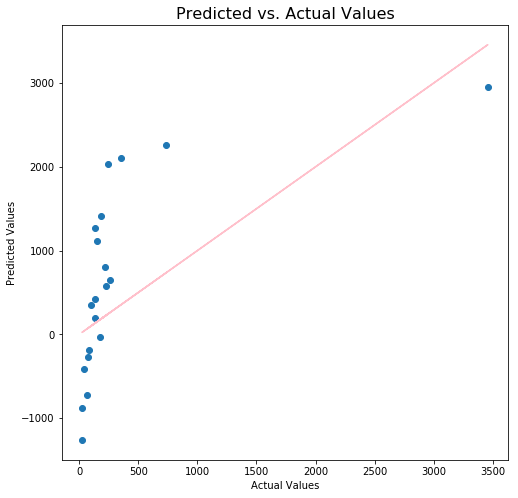

In [15]:
plt.figure(figsize=(8,8))
plt.title("Predicted vs. Actual Values", fontsize=16)
plt.scatter(y_test,predictions)
plt.plot(y_test, y_test, color="Pink") # identity line y=x
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

As we can see, it doesn't appear to be much of a strong model since the points do not follow a similar pattern as the line. Our natural observations can be confirmed by checking the actual accuracy of the graph, as seen below.

In [16]:
print("Accuracy (scale of 0 to 1): {}".format(model.score(X_test, y_test)))

Accuracy (scale of 0 to 1): -0.5793484684067627


As we can see, this score (with 1 being perfect and 0 being quite bad) is somewhat in the middle, not indicating a strong prediction.

## 4.2 Predicting based on the past 25 years
Below, we repeat similar steps for the past 25 years to see if we can improve predictions by eliminating earlier, perhaps mistakenly inputed data. First we calculate the frequencies with which UFOs have been sighted, and prepare the data for multiple linear regression and predictions.

In [17]:
# Create dictionary for frequency of sightings in wider range
years_25 = {}
for index, row in data_25.iterrows():
    yr = row['datetime'].strftime("%Y")
    if yr in years_25.keys():
        years_25[yr] = years_25[yr] + 1
    else:
        years_25[yr] = 1

# Create new column for years
data_25['Year'] = data_25.apply(lambda row: row['datetime'].strftime("%Y"), axis=1)


# Makes a dataframe for the years and frequency to use for Machine Learning Predicting
data_25 = pd.DataFrame(list(years_25.items()), columns=['Year','Frequency'])

# Casts year and hour to unsigned ints to make a linear regression model
data_25['Year'] = data_25['Year'].astype('uint32')
data_25['Frequency'] = data_25['Frequency'].astype('uint32')

data_25.head()

Year  Frequency
0   1990        204
1   1991        191
2   1992        198
3   1993        246
4   1994        350
5   1995       1180
6   1996        739
7   1997       1078
8   1998       1512
9   1999       2402
10  2000       2366
11  2001       2703
12  2002       2681
13  2003       3218
14  2004       3514
15  2005       3458
16  2006       3135
17  2007       3732
18  2008       4309
19  2009       3937
20  2010       3825
21  2011       4666
22  2012       6750
23  2013       6463

In [18]:
X = [[x] for x in data_25['Year'].values]
Y = [[y] for y in data_25['Frequency'].values]

# Create training and testing data from Year and Frequency
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y, test_size=0.3)

# Create and fit the model
lm = linear_model.LinearRegression()
model = lm.fit(X_train, y_train)

# Generate predictions for player Rating to compare with y_test data
predictions = lm.predict(X_test)

# Display first 10 results of our predicted player Ratings.
predictions[0:10]

array([[ -114.09752839],
       [ 4556.35022426],
       [ 5334.75818303],
       [ 2221.12634793],
       [  923.77974998],
       [  664.31043038],
       [ 4815.81954385],
       [ 4296.88090467]])

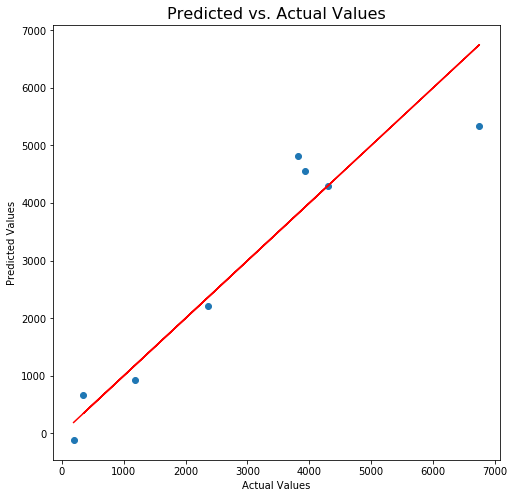

In [19]:
plt.figure(figsize=(8,8))
plt.title("Predicted vs. Actual Values", fontsize=16)
plt.scatter(y_test,predictions)
plt.plot(y_test, y_test, color="Red") # identity line y=x
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()

Judging from the closeness of the points to the line, we can guess that this a much stronger prediction than the one from 65 years. We can verify our hunches by calculating the accuracy score below.

In [20]:
print("Accuracy (scale of 0 to 1): {}".format(model.score(X_test, y_test)))

Accuracy (scale of 0 to 1): 0.8981682084932161


Considering that a score of 1 is considered perfect, we can say that any score above .8 is very strong, almost suspicious. We can guess that the score is this high because of the limited amount of data in the past 25 years.

For more information on machine learning, please visit https://www.sas.com/en_us/insights/analytics/machine-learning.html

# Conclusion

First, we plotted the locations of all of the reports from 2000-2013 in a heat map and saw that the most reports occured in metropolitan areas which is what we expected because of population density in those areas. Then we analyzed the frequency of reports for different variables in the data set. We looked at the state with the most reports from 2000-2013. We also looked at the most common times of reports such as the most popular year for reports from 2000-2013, the most common month of the year, the most common day of the week and the most common hour of the day for reports. We can conclude from the data that we have from 2000-2013, California had the most reports of UFOs, the most popular year was 2012, the most popular month of the year was July, the most popular day of the week was Saturday and the most popular hour of the day was 21:00 (Note: Most popular refers to the most reports in a time period). 

The duration map showed us that the longest sightings reported occurred on the east coast of the United States. Then through linear regression we hypothesized and proved that there is a positive trend between year and frequency (or number of reports). As far as machine learning predictions go, we can note that the frequency with which UFOs are being reported has been increasing greatly every year. In our machine learning section, we noted that we are able to strongly predict future year's frequencies based off of sightings in the past 25 years and see that they also will increase. We can guess that the data from the past 65 years did not yield proper predictions due to lack of technology and possible data loss in transitioning to a digital reporting system.

Thanks for taking the time to learn about UFOS. We appreciate any feedback on our project. If you see a UFO, you should report it to the NUFORC. You can do so by going to http://www.ufocenter.com/reportform.html and filling out the report form or call the hotline, you can find the number here http://www.nuforc.org/Report.html.